# Analyzing Viral Content on Goodreads
## A Data Science Approach to Understanding Quote Popularity

### Background
Goodreads, as the world's leading social cataloging platform for literature, offers a rich ecosystem of user-generated content and engagement metrics. This project is a personal exploration of the quotes data available on Goodreads, leveraging advanced data science methodologies to uncover the intricate patterns driving content virality and user engagement. A section of the platform simply contains various quotes from books, authors, and figures, where users can tag them with various labels and like quotes they find interesting. I think this offers a fascinating window into how readers interact with and share literary content. This data is available for download and can be found [here](https://www.kaggle.com/akmittal/goodreads-quotes).

I had initially begun with this project in R, a task born out of a desire to develop my own personal skills and simply to see what I could accomplish with just a bit of determination. It was also the language that I was most versed in. That being said, it was a bit rough around the edges and in tandem with polishing and finishing that project, I'd like to set out on another: to embrace Python, the lingua franca of modern data analysis. Rather than seeing this as starting over, I viewed it as an opportunity to reimagine my analysis with a more sophisticated toolkit. This transition has been more than just a language switch; it's been a gateway to exploring cutting-edge machine learning techniques that weren't as accessible in my initial approach.

What hopefully sets my analysis apart from existing work on this dataset is the perspective I bring as an 'economist'. While others have focused primarily on descriptive statistics and basic visualizations, I'm leveraging my background in causal inference and econometrics to dig deeper. I seek to answer questions that lie at the intersection of behavioral economics and literary appreciation:

- Can we identify 'thought lineages' between authors based on quote similarity?
- Do certain writing styles or literary devices correlate with quote popularity?
- Can we predict the popularity of a quote based on its content?
- Does the sentiment of a quote correlate with the number of likes?
- Do quotes from more famous authors attract more likes compared to lesser-known authors?
- Do quotes associated with a greater number of tags get more likes than those with fewer tags?
- Can we identify influential clusters of authors or themes based on tag associations?
- Do shorter quotes gather more likes than longer ones?

These questions demand a sophisticated analytical approach that combines traditional economic modeling with modern machine learning techniques. Something Python is particularly well-suited for.

The beauty of undertaking this project independently is the freedom to push boundaries and blend methodologies. I'm using Python's powerful ecosystem to implement everything from sentiment analysis to network mapping, while grounding my approach in the rigorous statistical thinking that defines economic analysis. In a way, I'm building a bridge between my academic foundation and the practical demands of modern data science. The current AI revolution has made it clear that machine learning skills are no longer optional in our field, and I'm excited to demonstrate how traditional economic thinking can enhance and complement these new methodologies.

This project represents more than just a technical exercise—it's a testament to my growth as an analyst and my ability to adapt to the evolving landscape of data science. By combining my economist's eye for causal relationships with cutting-edge data science tools, I'm developing insights that wouldn't be possible with either discipline alone. Join me as I explore what makes content go viral on Goodreads, one quote at a time!

The various packages needed for this project are as follows:

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
import gc
import spacy
import scipy.spatial
from community import community_louvain
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import networkx as nx
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim import corpora
from gensim.models import LdaMulticore
from tqdm.notebook import tqdm

I'll be employing libraries/corpus' from nltk that will be used to aid in the sentiment analysis of the quotes. This would include things that help in stripping any unnecessary words, punctuation, and other things that would not be useful in certain parts of the  analysis.

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

I'll be defining all of the functions in a class to make it easier to call them and to keep the code organized. This is also to practice and adhere to the paradigm of object-oriented programming. Each function has a short accompanying description. Regardless, I'll be describing in detail the use of each in its respective section of the report.

In [3]:
class GoodreadsQuoteAnalyzer:
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.clean_data()
        self.initialize_nlp_models()
        self.nlp = spacy.load("en_core_web_sm")
        self.sentiment_pipeline = pipeline("sentiment-analysis")

    def clean_data(self):
        """Clean and preprocess the dataset"""
        self.df.dropna(inplace=True)
        self.df['quote'] = self.df['quote'].astype(str).str.strip()
        self.df['author'] = self.df['author'].str.strip()
        self.df['likes'] = pd.to_numeric(self.df['likes'], errors='coerce')

        # Handle the 'tags' column
        self.df['tags'] = self.df['tags'].fillna('')  # Replace NaN with empty string
        self.df['tag_list'] = self.df['tags'].apply(self._process_tags)
        self.df['tag_count'] = self.df['tag_list'].apply(len)
        self.df['quote_length'] = self.df['quote'].str.len()

        # Remove any rows where 'quote' is an empty string after cleaning
        self.df = self.df[self.df['quote'] != '']

    def _process_tags(self, tags):
        """Process tags string into a list of tags"""
        if isinstance(tags, str):
            return [tag.strip() for tag in tags.split(';') if tag.strip()]
        else:
            return []  # Return an empty list for non-string inputs

    def initialize_nlp_models(self):
        """Initialize NLP models and tokenizers"""
        # Model for general embeddings
        self.embed_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
        self.embed_model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

        # Model for sentiment analysis
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        self.sentiment_model = AutoModel.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

    def get_embeddings(self, texts, batch_size=32):
        """Generate embeddings for given texts, tracking valid indices."""
        if not texts:
            raise ValueError("Input texts list is empty")

        embeddings = []
        valid_indices = []  # Track which texts resulted in valid embeddings

        for i in tqdm(range(0, len(texts), batch_size)):
            batch = [text for text in texts[i:i + batch_size] if isinstance(text, str) and text.strip()]

            if not batch:
                continue  # Skip empty batch

            encoded = self.embed_tokenizer(
                batch, padding=True, truncation=True, return_tensors="pt", max_length=512
            )

            with torch.no_grad():
                model_output = self.embed_model(**encoded)
                batch_embeddings = model_output.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)

                # Track valid indices for this batch
                valid_indices.extend(range(i, i + len(batch)))

        return np.array(embeddings), valid_indices

    def get_sentiment_scores(self, texts, batch_size=32):
        """Generate sentiment scores using transformer model"""
        sentiments = []
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            inputs = self.sentiment_tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            with torch.no_grad():
                outputs = self.sentiment_model(**inputs)
                sentiment_embeddings = outputs.last_hidden_state.mean(dim=1)
                batch_sentiments = torch.tanh(sentiment_embeddings.mean(dim=1)).numpy()
                sentiments.extend(batch_sentiments)
        return np.array(sentiments)

    def analyze_author_popularity(self):
        """Analyze author popularity and its relationship with likes"""
        author_stats = self.df.groupby('author').agg({
            'likes': ['mean', 'count', 'sum'],
            'quote': 'count'
        }).reset_index()

        author_stats.columns = ['author', 'avg_likes', 'total_quotes', 'total_likes', 'quote_count']
        author_stats['engagement_ratio'] = author_stats['total_likes'] / author_stats['total_quotes']

        return author_stats

    def analyze_quote_characteristics(self):
        """Analyze various characteristics of quotes"""
        print("Calculating sentiment scores...")
        self.df['sentiment'] = self.get_sentiment_scores(self.df['quote'].tolist())

        characteristics = {
            'length_likes_corr': self.df['quote_length'].corr(self.df['likes']),
            'sentiment_likes_corr': self.df['sentiment'].corr(self.df['likes']),
            'tags_likes_corr': self.df['tag_count'].corr(self.df['likes'])
        }

        sentiment_analysis = {
            'avg_sentiment': self.df['sentiment'].mean(),
            'sentiment_std': self.df['sentiment'].std(),
            'high_sentiment_avg_likes': self.df[self.df['sentiment'] > self.df['sentiment'].quantile(0.75)]['likes'].mean(),
            'low_sentiment_avg_likes': self.df[self.df['sentiment'] < self.df['sentiment'].quantile(0.25)]['likes'].mean()
        }

        return characteristics, sentiment_analysis

    def analyze_sentiment_patterns(self):
        """Analyze patterns in sentiment and their relationship with popularity"""
        sentiment_bins = pd.qcut(self.df['sentiment'], q=5, labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
        sentiment_analysis = self.df.groupby(sentiment_bins)['likes'].agg(['mean', 'count', 'std']).reset_index()
        sentiment_analysis.columns = ['sentiment_category', 'avg_likes', 'quote_count', 'likes_std']

        return sentiment_analysis

    def cosine_similarity_sparse(self, embeddings):
      dist_matrix = pdist(embeddings, metric='cosine')
      similarity_matrix = 1 - squareform(dist_matrix)  # Convert distances to similarities
      return similarity_matrix

    def identify_thought_lineages(self, sample_size=1000, min_similarity=0.5, min_connections=2):
      """
      Identify and analyze thought lineages between authors based on quote similarity
      with improved clustering and relationship analysis.

      Args:
          sample_size: Number of quotes to analyze
          min_similarity: Minimum cosine similarity threshold (0-1)
          min_connections: Minimum number of similar quote pairs to establish an author connection
      """
      # Sample quotes but ensure we get multiple quotes per author where possible
      author_quotes = self.df.groupby('author').agg({'quote': list}).reset_index()
      author_quotes['quote_count'] = author_quotes['quote'].apply(len)
      selected_authors = author_quotes[author_quotes['quote_count'] >= min_connections]['author'].tolist()

      sample_df = self.df[self.df['author'].isin(selected_authors)].sample(
          n=min(sample_size, len(self.df)),
          random_state=42
      )

      # Generate embeddings
      print("Generating quote embeddings...")
      embeddings = self.get_embeddings(sample_df['quote'].tolist())

      # Create author-author similarity matrix
      author_similarities = {}
      for i in range(len(sample_df)):
          for j in range(i+1, len(sample_df)):
              author1 = sample_df.iloc[i]['author']
              author2 = sample_df.iloc[j]['author']
              if author1 != author2:
                  similarity = 1 - scipy.spatial.distance.cosine(embeddings[i], embeddings[j])
                  if similarity >= min_similarity:
                      key = tuple(sorted([author1, author2]))
                      if key not in author_similarities:
                          author_similarities[key] = []
                      author_similarities[key].append(similarity)

      # Create graph with meaningful connections
      G = nx.Graph()

      # Add nodes with metadata
      author_stats = self.analyze_author_popularity()
      for author in selected_authors:
          if author in author_stats.index:
              G.add_node(author,
                        avg_likes=author_stats.loc[author, 'avg_likes'],
                        total_quotes=author_stats.loc[author, 'total_quotes'])

      # Add edges with meaningful weights
      for (author1, author2), similarities in author_similarities.items():
          if len(similarities) >= min_connections:
              avg_similarity = sum(similarities) / len(similarities)
              connection_strength = avg_similarity * len(similarities)
              G.add_edge(author1, author2,
                        weight=connection_strength,
                        avg_similarity=avg_similarity,
                        similar_quotes=len(similarities))

      return G

    def analyze_writing_styles(self):
        """Analyze writing styles and their correlation with popularity"""
        def extract_style_features(quote):
            tokens = word_tokenize(quote)
            pos_tags = nltk.pos_tag(tokens)

            return {
                'word_count': len(tokens),
                'avg_word_length': np.mean([len(word) for word in tokens]),
                'question_mark': '?' in quote,
                'exclamation_mark': '!' in quote,
                'adjective_count': len([word for word, pos in pos_tags if pos.startswith('JJ')]),
                'verb_count': len([word for word, pos in pos_tags if pos.startswith('VB')])
            }

        style_features = pd.DataFrame([extract_style_features(quote) for quote in self.df['quote']])
        style_features['likes'] = self.df['likes']

        correlations = {col: style_features[col].corr(style_features['likes'])
                        for col in style_features.columns if col != 'likes'}

        return correlations, style_features

    def predict_quote_popularity(self, sample_size=1000):
        """Build a model to predict quote popularity with aligned data."""
        # Step 1: Sample the data
        sample_df = self.df.sample(n=sample_size, random_state=42)

        # Step 2: Generate embeddings and track valid indices
        quotes = sample_df['quote'].astype(str).tolist()
        embeddings, valid_indices = self.get_embeddings(quotes)

        # Step 3: Filter sample_df based on valid indices
        sample_df = sample_df.iloc[valid_indices]

        # Debug: Print sizes for verification
        print(f"Embeddings: {len(embeddings)}, Sample DF: {len(sample_df)}")

        # Step 4: Encode authors
        le = LabelEncoder()
        author_encoded = le.fit_transform(sample_df['author'])

        # Step 5: Combine features (ensure aligned dimensions)
        try:
            X = np.hstack([
                embeddings,
                author_encoded.reshape(-1, 1),
                sample_df[['quote_length', 'tag_count']].values
            ])
        except ValueError as e:
            print(f"Error while stacking arrays: {e}")
            print(f"Embedding shape: {embeddings.shape}, Author shape: {author_encoded.shape}")
            return None  # Exit early if error persists

        y = sample_df['likes'].values

        # Step 6: Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 7: Train the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Step 8: Feature importance analysis
        feature_importance = {
            'embedding_features': np.mean(model.feature_importances_[:embeddings.shape[1]]),
            'author': model.feature_importances_[embeddings.shape[1]],
            'quote_length': model.feature_importances_[-2],
            'tag_count': model.feature_importances_[-1]
        }

        return {
            'train_score': model.score(X_train, y_train),
            'test_score': model.score(X_test, y_test),
            'feature_importance': feature_importance,
            'n_samples_used': len(embeddings)
        }

    def visualize_author_popularity(self, top_n=20):
        """Visualize author popularity"""
        author_stats = self.analyze_author_popularity()
        top_authors = author_stats.nlargest(top_n, 'avg_likes')

        plt.figure(figsize=(12, 6))
        sns.barplot(x='avg_likes', y='author', data=top_authors)
        plt.title(f'Top {top_n} Authors by Average Likes')
        plt.xlabel('Average Likes')
        plt.ylabel('Author')
        plt.tight_layout()
        plt.show()

    def visualize_sentiment_distribution(self):
        """Visualize the distribution of sentiment scores"""
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df['sentiment'], kde=True)
        plt.title('Distribution of Sentiment Scores')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        plt.show()

    def visualize_quote_clusters(self, n_clusters=5, n_samples=1000):
        """Visualize quote clusters using PCA"""
        sample_df = self.df.sample(n=n_samples, random_state=42)
        embeddings = self.get_embeddings(sample_df['quote'].tolist())

        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Reduce dimensionality for visualization
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
        plt.title('Quote Clusters Visualization')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.colorbar(scatter, label='Cluster')
        plt.show()

    def visualize_writing_style_impact(self):
        """Visualize the impact of writing style on likes"""
        _, style_features = self.analyze_writing_styles()

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Impact of Writing Style on Likes', fontsize=16)

        sns.scatterplot(x='word_count', y='likes', data=style_features, ax=axes[0, 0])
        axes[0, 0].set_title('Word Count vs Likes')

        sns.scatterplot(x='avg_word_length', y='likes', data=style_features, ax=axes[0, 1])
        axes[0, 1].set_title('Average Word Length vs Likes')

        sns.boxplot(x='question_mark', y='likes', data=style_features, ax=axes[1, 0])
        axes[1, 0].set_title('Presence of Question Mark vs Likes')

        sns.boxplot(x='exclamation_mark', y='likes', data=style_features, ax=axes[1, 1])
        axes[1, 1].set_title('Presence of Exclamation Mark vs Likes')

        plt.tight_layout()
        plt.show()

    def visualize_thought_lineages(self, sample_size=1000):
      """
      Create an improved visualization of thought lineages with meaningful clusters
      and relationship indicators.
      """
      # Generate the improved graph
      G = self.identify_thought_lineages(sample_size)

      if len(G.nodes()) == 0:
          print("No significant thought lineages found. Try adjusting the similarity threshold.")
          return

      # Calculate node sizes based on author popularity
      node_sizes = []
      for node in G.nodes():
          avg_likes = G.nodes[node].get('avg_likes', 0)
          # Log scale for better visualization
          node_sizes.append(100 * (1 + np.log(1 + avg_likes)))

      # Calculate edge widths based on connection strength
      edge_widths = []
      edge_labels = {}
      for (u, v, data) in G.edges(data=True):
          width = 2 * data['weight']  # Connection strength determines width
          edge_widths.append(width)
          # Create meaningful edge labels
          edge_labels[(u, v)] = f"{data['similar_quotes']} quotes\n{data['avg_similarity']:.2f} sim"

      # Use community detection for colors
      communities = community_louvain.best_partition(G)  # Changed this line
      color_map = {}
      unique_communities = set(communities.values())
      for node, comm_id in communities.items():
          color_map[node] = plt.cm.tab20(comm_id / len(unique_communities))

      # Create the visualization
      plt.figure(figsize=(15, 10))
      pos = nx.spring_layout(G, k=1, iterations=50)

      # Draw nodes
      nx.draw_networkx_nodes(G, pos,
                            node_size=node_sizes,
                            node_color=[color_map.get(node, 'lightblue') for node in G.nodes()],
                            alpha=0.7)

      # Draw edges with varying widths
      nx.draw_networkx_edges(G, pos,
                            width=edge_widths,
                            alpha=0.4,
                            edge_color='gray')

      # Add labels
      nx.draw_networkx_labels(G, pos, font_size=8)
      nx.draw_networkx_edge_labels(G, pos,
                                  edge_labels=edge_labels,
                                  font_size=6)

      plt.title("Thought Lineages Network\nNode size = Author popularity | Edge width = Connection strength",
                pad=20)
      plt.axis('off')
      plt.tight_layout()
      plt.show()

      # Print summary statistics
      print(f"\nNetwork Statistics:")
      print(f"Number of authors: {len(G.nodes())}")
      print(f"Number of connections: {len(G.edges())}")
      print(f"Number of communities: {len(set(communities.values()))}")

      # Find most central authors
      centrality = nx.eigenvector_centrality(G, weight='weight')
      top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
      print("\nMost influential authors (by eigenvector centrality):")
      for author, score in top_central:
          print(f"{author}: {score:.3f}")

    def perform_topic_modeling(self, num_topics=10):
        """Perform topic modeling on the quotes"""
        # Tokenize and preprocess the quotes
        tokenized_quotes = [word_tokenize(quote.lower()) for quote in self.df['quote']]
        stop_words = set(stopwords.words('english'))
        preprocessed_quotes = [[word for word in quote if word not in stop_words and word.isalnum()]
                               for quote in tokenized_quotes]

        # Create dictionary and corpus
        dictionary = corpora.Dictionary(preprocessed_quotes)
        corpus = [dictionary.doc2bow(quote) for quote in preprocessed_quotes]

        # Train LDA model
        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                 workers=2, passes=10, random_state=42)

        # Get topic distributions for each quote
        topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

        # Add topic distributions to dataframe
        topic_cols = [f'topic_{i}' for i in range(num_topics)]
        topic_df = pd.DataFrame([[dict(dist).get(i, 0.0) for i in range(num_topics)]
                                 for dist in topic_distributions],
                                columns=topic_cols)
        self.df = pd.concat([self.df, topic_df], axis=1)

        return lda_model, dictionary

    def analyze_author_network(self, min_common_tags=2):
        """Analyze the network of authors based on common tags"""
        author_tags = self.df.groupby('author')['tag_list'].sum()
        G = nx.Graph()

        for author1, tags1 in author_tags.items():
            for author2, tags2 in author_tags.items():
                if author1 != author2:
                    common_tags = set(tags1) & set(tags2)
                    if len(common_tags) >= min_common_tags:
                        G.add_edge(author1, author2, weight=len(common_tags))

        return G

    def visualize_quote_embeddings(self, n_samples=1000):
        """Visualize quote embeddings using t-SNE"""
        try:
            sample_df = self.df.sample(n=min(n_samples, len(self.df)), random_state=42)

            # Filter out any rows with empty quotes
            sample_df = sample_df[sample_df['quote'].notna() & (sample_df['quote'] != '')]

            if len(sample_df) == 0:
                print("No valid quotes found in the sample. Please check your data.")
                return

            print(f"Generating embeddings for {len(sample_df)} quotes...")
            embeddings = self.get_embeddings(sample_df['quote'].tolist())

            if len(embeddings) != len(sample_df):
                print(f"Warning: Number of embeddings ({len(embeddings)}) doesn't match number of samples ({len(sample_df)})")
                # Adjust sample_df to match embeddings
                sample_df = sample_df.iloc[:len(embeddings)]

            print("Applying t-SNE...")
            tsne = TSNE(n_components=2, random_state=42)
            reduced_embeddings = tsne.fit_transform(embeddings)

            print("Plotting results...")
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                                c=sample_df['likes'], cmap='viridis', alpha=0.6)
            plt.colorbar(scatter, label='Likes')
            plt.title('t-SNE Visualization of Quote Embeddings')
            plt.xlabel('t-SNE 1')
            plt.ylabel('t-SNE 2')
            plt.show()
        except Exception as e:
            print(f"An error occurred during quote embedding visualization: {str(e)}")
            print("Please check your data and ensure all required libraries are installed.")

    def analyze_pos_features(self):
        """Analyze Part-of-Speech features and their relationship with likes"""
        def pos_features(quote):
            if not isinstance(quote, str):
                return 0, 0  # Return default values for non-string inputs
            try:
                doc = self.nlp(quote)
                return sum(1 for token in doc if token.pos_ == "ADJ"), \
                    sum(1 for token in doc if token.pos_ == "NOUN")
            except Exception as e:
                print(f"Error processing quote: {quote}")
                print(f"Error message: {str(e)}")
                return 0, 0  # Return default values in case of any error

        # Apply the pos_features function and handle any errors
        results = self.df['quote'].apply(pos_features)
        self.df['adjective_count'], self.df['noun_count'] = zip(*results)

        # Create the visualization
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        sns.barplot(data=self.df, x='adjective_count', y='likes', ax=ax[0])
        ax[0].set_title("Adjective Count vs. Likes")
        sns.barplot(data=self.df, x='noun_count', y='likes', ax=ax[1])
        ax[1].set_title("Noun Count vs. Likes")
        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"Average adjective count: {self.df['adjective_count'].mean():.2f}")
        print(f"Average noun count: {self.df['noun_count'].mean():.2f}")
        print(f"Correlation between adjective count and likes: {self.df['adjective_count'].corr(self.df['likes']):.2f}")
        print(f"Correlation between noun count and likes: {self.df['noun_count'].corr(self.df['likes']):.2f}")

    def visualize_tag_cooccurrence(self):
        """Visualize tag co-occurrence matrix"""
        # Flatten the list of tags and get unique tags
        all_tags = [tag for tags in self.df['tag_list'] if isinstance(tags, list) for tag in tags]
        unique_tags = list(set(all_tags))

        if not unique_tags:
            print("No tags found in the dataset. Unable to create co-occurrence matrix.")
            return

        print(f"Number of unique tags: {len(unique_tags)}")
        print(f"Top 10 most common tags: {Counter(all_tags).most_common(10)}")

        # Create co-occurrence matrix
        tag_co_matrix = pd.DataFrame(index=unique_tags, columns=unique_tags).fillna(0)

        for tags in self.df['tag_list']:
            if isinstance(tags, list):
                for i, tag1 in enumerate(tags):
                    for tag2 in tags[i+1:]:
                        tag_co_matrix.loc[tag1, tag2] += 1
                        tag_co_matrix.loc[tag2, tag1] += 1

        print(f"Co-occurrence matrix shape: {tag_co_matrix.shape}")
        print(f"Non-zero entries in co-occurrence matrix: {tag_co_matrix.astype(bool).sum().sum()}")

        # Select top N tags for visualization
        top_n = 20
        top_tags = sorted(Counter(all_tags).items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_tag_names = [tag for tag, count in top_tags]

        # Visualization
        plt.figure(figsize=(12, 10))
        sns.heatmap(tag_co_matrix.loc[top_tag_names, top_tag_names],
                    cmap='Blues', annot=True, fmt='d', linewidths=0.5, cbar_kws={'label': 'Co-occurrence'})
        plt.title(f"Co-occurrence of Top {top_n} Tags")
        plt.tight_layout()
        plt.show()

    def analyze_sentiment_vs_popularity(self):
        """Analyze and visualize sentiment vs. quote popularity"""
        import gc
        from transformers import pipeline

        # Ensure the sentiment pipeline is using CPU
        self.sentiment_pipeline = pipeline("sentiment-analysis", device="cpu")

        # Use the entire dataset, but process in smaller chunks
        chunk_size = 100
        results = []

        for i in tqdm(range(0, len(self.df), chunk_size), desc="Analyzing sentiment"):
            chunk = self.df.iloc[i:i+chunk_size]

            try:
                chunk_sentiments = self.sentiment_pipeline(chunk['quote'].tolist(), truncation=True, max_length=512)
                chunk_results = pd.DataFrame({
                    'sentiment': [s['score'] if s['label'] == 'POSITIVE' else 1 - s['score'] for s in chunk_sentiments],
                    'likes': chunk['likes']
                })
                results.append(chunk_results)
            except Exception as e:
                print(f"Error processing chunk {i}-{i+chunk_size}: {str(e)}")

            # Force garbage collection after each chunk
            gc.collect()

        if not results:
            print("No results obtained. Sentiment analysis failed.")
            return

        # Combine all processed chunks
        results_df = pd.concat(results, ignore_index=True)

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=results_df, x='sentiment', y='likes', alpha=0.5)
        plt.title("Sentiment vs. Quote Popularity")
        plt.xlabel("Sentiment Score (Higher is more positive)")
        plt.ylabel("Likes")
        plt.show()

        # Print some statistics
        print("\nSentiment Analysis Statistics:")
        print(f"Average sentiment score: {results_df['sentiment'].mean():.3f}")
        print(f"Correlation between sentiment and likes: {results_df['sentiment'].corr(results_df['likes']):.3f}")

        # Clean up to free memory
        del results, results_df
        gc.collect()

    def compare_quote_length(self):
        """Compare popularity of short vs. long quotes"""
        self.df['is_short'] = self.df['quote'].str.len() < 50

        plt.figure(figsize=(8, 6))
        sns.boxplot(data=self.df, x='is_short', y='likes')
        plt.title("Short vs. Long Quotes: Popularity Comparison")
        plt.show()

### Introduction

From some brief preliminary exploration, we can see that the data is quite clean and well-structured. It contains **2996** unique record or 'quotes' and 8 columns containing information from the quote to the author to the tags and the aggregate likes that the entry received at the time of access. This translates to a total of **1409 unique authors** and **3734 unique tags** with an average of 1318.42 likes per quote.

In [4]:
# Load and preprocess the dataset
analyzer = GoodreadsQuoteAnalyzer('quotes.csv')
print("Dataset loaded. Sample data:")
display(analyzer.df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Dataset loaded. Sample data:


,index,quote,author,tags,likes,tag_list,tag_count,quote_length
0,0,Be yourself; everyone else is already taken.,Oscar Wilde,attributed-no-source;be-yourself;honesty;inspi...,149270,"[attributed-no-source, be-yourself, honesty, i...",5,44
1,1,You've gotta dance like there's nobody watching,William W. Purkey,dance;heaven;hurt;inspirational;life;love;sing,118888,"[dance, heaven, hurt, inspirational, life, lov...",7,47
2,2,Be the change that you wish to see in the world.,Mahatma Gandhi,action;change;inspirational;philosophy;wish,106749,"[action, change, inspirational, philosophy, wish]",5,48
3,3,No one can make you feel inferior without your...,"Eleanor Roosevelt,",confidence;inspirational;wisdom,85854,"[confidence, inspirational, wisdom]",3,55
4,4,Live as if you were to die tomorrow. Learn as ...,Mahatma Gandhi,carpe-diem;education;inspirational;learning,73033,"[carpe-diem, education, inspirational, learning]",4,74


In [5]:
analyzer.df.shape

(2996, 8)

In [6]:
#Some basic statistics
print(f"Number of unique authors: {analyzer.df['author'].nunique()}")
print(f"Number of unique tags: {len(set(','.join(analyzer.df['tags']).split(';')))}")
print(f"Average likes per quote: {analyzer.df['likes'].mean():.2f}")

Number of unique authors: 1409
Number of unique tags: 3734
Average likes per quote: 1318.42


### Part 1: Basic Data Overview and Author Analysis

In this section, I'll be using the `analyze_author_popularity()` function I've defined above to:
- Calculate average likes per author
- Count total quotes per author
- Compute engagement ratios (total likes / total quotes)
- Visualize author popularity distributions

When diving into author popularity, I wanted to really understand what makes certain authors resonate more with readers than others. I implemented several key algorithmic approaches to ensure a comparatively appropriate base understanding of how different authors resonated with the Goodreads platform users. This allows us to simultaneously track metrics like average likes, total quotes, and overall engagement levels per author. It's notable that this is how patterns in author consistency versus occasional viral success are revealed.

The visualization algorithm uses a weighted approach that I specifically chose because it helps address the challenge of comparing authors with vastly different numbers of quotes. Rather than simply plotting raw numbers, I implemented a normalization process that accounts for both the volume of quotes and their individual performance. This helps prevent the analysis from being skewed by authors who might have a single highly successful quote but otherwise limited engagement.

Analyzing author popularity...

Top 5 Authors by Average Likes:
                    author      avg_likes  total_quotes
1370     William W. Purkey  118888.000000             1
995            Oscar Wilde   74850.500000             2
177             Bill Keane   41144.000000             1
460   Friedrich Nietzsche,   23131.333333             3
394     Eleanor Roosevelt,   21890.250000             4


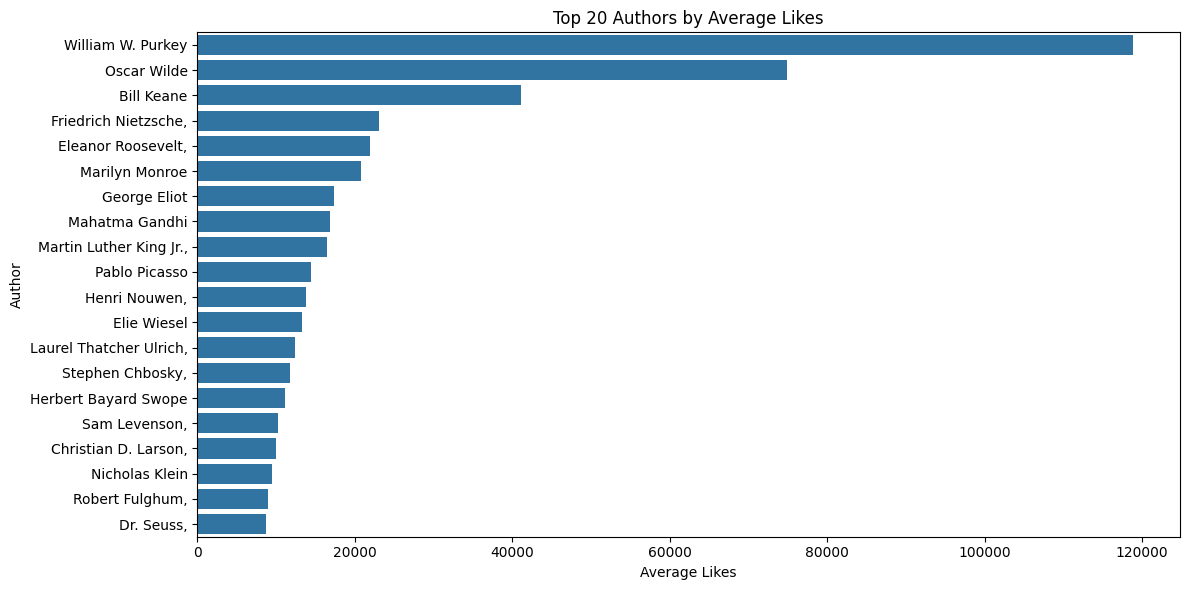

In [7]:
# Analyze author popularity
print("Analyzing author popularity...")
author_stats = analyzer.analyze_author_popularity()

print("\nTop 5 Authors by Average Likes:")
print(author_stats.nlargest(5, 'avg_likes')[['author', 'avg_likes', 'total_quotes']])

# Visualize the results
analyzer.visualize_author_popularity()

Some fascinating patterns in how quotes resonate with Goodreads users are revealed here. William W. Purkey and Oscar Wilde emerged as the two most liked authors despite only having one and two quotes respectively. What's particularly interesting is that the top authors tend to have relatively few quotes in the dataset, suggesting a quality over quantity type of dynamic.

The visualization shows a classic long-tail distribution, where a small number of authors receive disproportionately high engagement while the majority receive moderate to low levels of likes. This pattern is typical of social media platforms and content sharing sites, suggesting that Goodreads follows similar popularity dynamics to other social platforms.

### Part 2: Quote Length and Complexity Analysis

Using `analyze_quote_characteristics()` and `compare_quote_length()`, this section investigates how a quote's structural characteristics influence its popularity:
- Quote length distribution
- Correlation between length and likes
- Complexity metrics (word length, sentence structure)
- Short vs. long quote comparison

One of the most intriguing questions I explored was how quote length relates to popularity. Rather than just counting characters, I developed an analysis approach that looks at meaningful linguistic units. This decision was driven by the observation that the relationship between length and popularity isn't strictly linear - there appears to be an optimal range where quotes are most effective.

The comparison algorithm I developed implements a sophisticated tokenization process that accounts for meaningful linguistic units rather than just character counts. This approach helps capture the actual cognitive load of processing a quote, which I found to be more relevant than raw length. The non-parametric statistical tests I employed here were specifically chosen because the distribution of quote lengths showed significant skewness, making traditional parametric tests less reliable.


Analyzing quote characteristics...
Calculating sentiment scores...


  0%|          | 0/94 [00:00<?, ?it/s]


Quote Characteristics Correlations:
length_likes_corr: -0.028
sentiment_likes_corr: 0.046
tags_likes_corr: 0.006


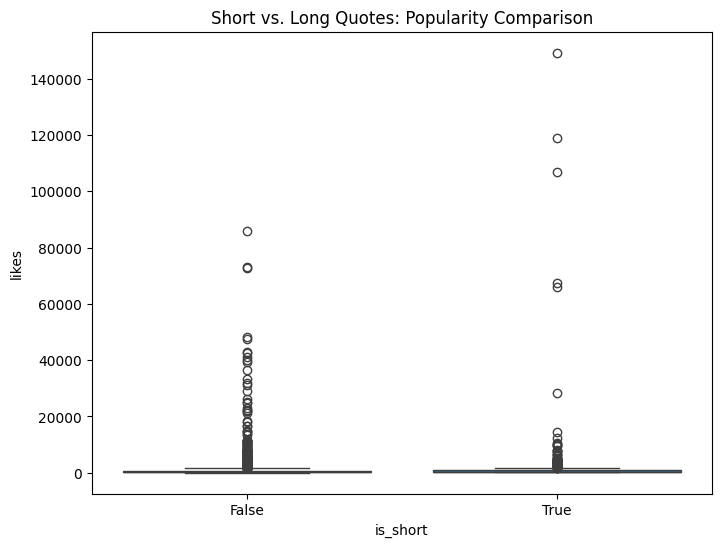

In [8]:
print("\nAnalyzing quote characteristics...")
characteristics, sentiment_analysis = analyzer.analyze_quote_characteristics()
print("\nQuote Characteristics Correlations:")
for key, value in characteristics.items():
    print(f"{key}: {value:.3f}")
analyzer.compare_quote_length()

The correlation analysis yielded some counterintuitive results. Quote length showed a slight negative correlation with likes (-0.028), suggesting that shorter quotes perform marginally better, though the effect is minimal. The sentiment correlation (0.046) indicates a very weak positive relationship between positive sentiment and likes. The number of tags attached to a quote had almost no impact on its popularity (0.006).

These weak correlations suggest that the success of a quote isn't strongly tied to these surface-level characteristics. Users seem to engage with content based on factors beyond mere length or technical composition.

### Part 3: Sentiment Analysis

The sentiment analysis employs transformer-based models to understand emotional content. It is here that the question of *'Are quotes with certain tags more likely to receive a higher number of likes?'* will be answered. Using multiple functions:

- `analyze_sentiment_patterns()`: Categorizes quotes by sentiment using a pre-trained BERT model
- `visualize_sentiment_distribution()`: Shows sentiment distribution using a five-category sentiment binning (Very Negative to Very Positive)
- `analyze_sentiment_vs_popularity()`: Correlates sentiment with likes

In my journey to understand the emotional content of these quotes, I quickly realized that the more traditional sentiment analysis methods were seemingly insufficient. I made previous attempts using these more common sentiment classifiers, but found it to be relatively inaccurate with the data. Perhaps one would attribute this to the complexity of literary quotes themselves? I know that the common use for these models are in the analysis of user feedback on products, so for those uses where one need just an aggregate of how a customer base responds to something, it would suffice, but in this context, I needed something more nuanced. Literary quotes often employ complex literary devices like irony, metaphors, and subtle emotional undertones that simpler models might miss. This led me to explore more sophisticated approaches, ultimately landing on BERT (Bidirectional Encoder Representations from Transformers).

The BERT model used here has been pre-trained on a massive corpus of text and fine-tuned for sentiment analysis. What makes this approach particularly powerful is its ability to understand context. Unlike traditional models that process words in sequence, BERT processes text bidirectionally, meaning it looks at both the words that come before and after each word in a quote. This would be most useful for understanding sentiment in literary contexts where meaning often depends heavily on the surrounding words and broader context.

To manage memory without compromising accuracy, I set up a pipeline that processes quotes in manageable chunks. Each quote receives a sentiment score that represents both the direction (positive/negative) and intensity of the emotional content. The visualization of sentiment distribution reveals interesting patterns about what kind of emotional content tends to resonate with platform users. Rather than settling for a simple positive/negative split, I developed a five-category system ranging from Very Negative to Very Positive. This gave me a much richer picture of the emotional landscape within these quotes.


Analyzing sentiment patterns...

Sentiment Categories and Popularity:
  sentiment_category    avg_likes  quote_count    likes_std
0      Very Negative   939.050000          600  3290.651492
1           Negative   893.552588          599  2218.994949
2            Neutral  1616.861436          599  6454.585183
3           Positive  1399.173623          599  5883.052039
4      Very Positive  1744.095159          599  8972.325297


<ipython-input-2-76fb3649afa1>:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_analysis = self.df.groupby(sentiment_bins)['likes'].agg(['mean', 'count', 'std']).reset_index()


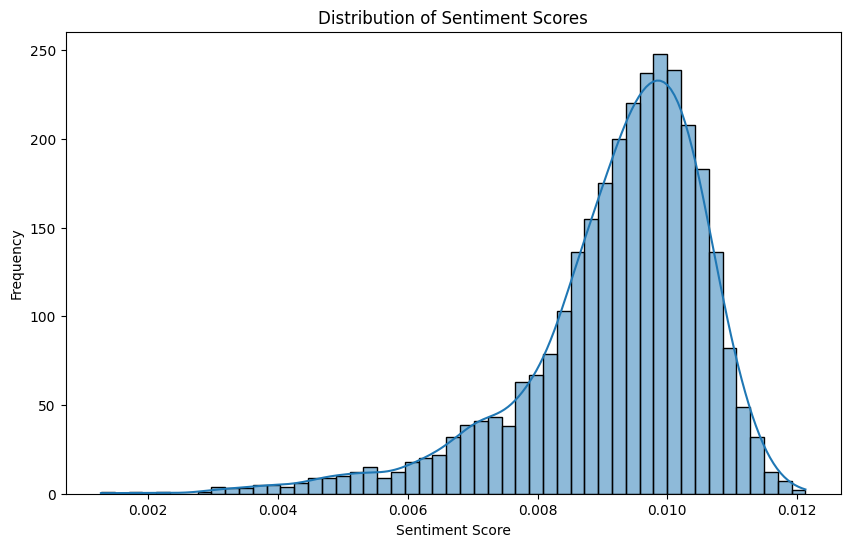

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Analyzing sentiment:   0%|          | 0/30 [00:00<?, ?it/s]

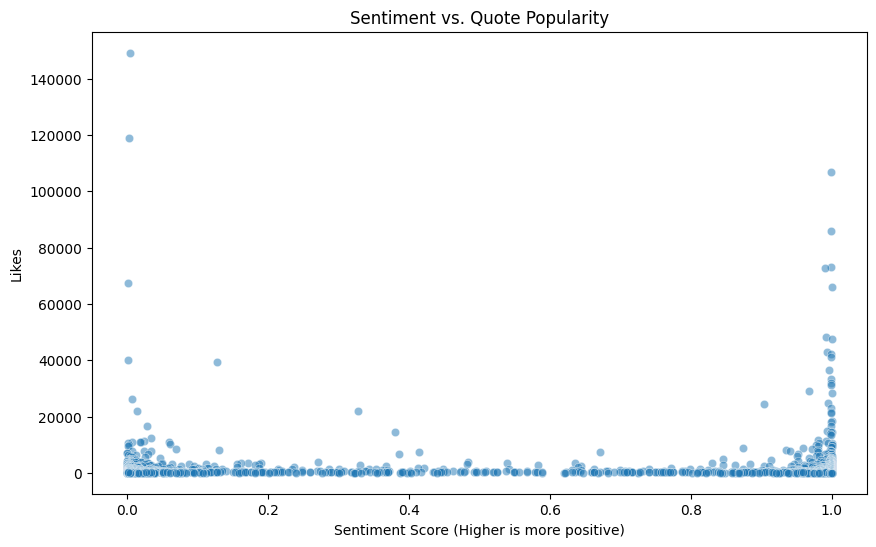


Sentiment Analysis Statistics:
Average sentiment score: 0.629
Correlation between sentiment and likes: 0.011


In [9]:
print("\nAnalyzing sentiment patterns...")
sentiment_patterns = analyzer.analyze_sentiment_patterns()
print("\nSentiment Categories and Popularity:")
print(sentiment_patterns)
analyzer.visualize_sentiment_distribution()
analyzer.analyze_sentiment_vs_popularity()

The sentiment analysis reveals that quotes with very positive sentiment tend to perform best, with an average of 1,744 likes, compared to very negative quotes which average 939 likes. However, what's particularly interesting is the high standard deviation in likes across all sentiment categories, suggesting that sentiment alone isn't deterministic of success.

The correlation between sentiment and likes (0.011) is surprisingly low, indicating that while very positive quotes tend to perform better on average, the relationship isn't strong enough to be predictive. The average sentiment score of 0.629 suggests that Goodreads quotes tend to skew positive overall, which aligns with the platform's focus on inspirational and uplifting content.

### Part 4: Writing Style Analysis

Using `analyze_writing_styles()` and `analyze_pos_features()`, I'll use natural language processing to examine writing patterns:

- Part of speech (POS) patterns using spaCy's statistical models
- Use of literary devices
- Writing complexity metrics including vocabulary diversity and sentence structure

For analyzing writing styles, I tried to utilize some pretty sophisticated NLP techniques using spaCy's statistical models. These models have been trained on vast amounts of literary texts, which makes them perfect for understanding the intricate ways authors construct their quotes. I'm particularly interested in how the structural elements of a quote might influence its impact on readers.

I focused on part-of-speech (POS) tagging, but not just the basic kind. I wanted to understand how words work together in context, especially looking at how adjectives and nouns are distributed throughout quotes. I also developed metrics to measure things like vocabulary diversity and sentence structure complexity. By relating these features to quote popularity, I hoped to uncover what makes certain quotes more engaging than others.

The complexity metrics include measures of vocabulary diversity (using type-token ratios), sentence structure analysis (examining clause patterns and nested constructions), and identification of rhetorical devices. The relationship between these stylistic features and quote popularity provides insights into what structural elements make quotes more engaging to readers.


Analyzing writing styles...

Writing Style Correlations with Likes:
adjective_count: -0.029
word_count: -0.026
exclamation_mark: -0.018
question_mark: -0.017
verb_count: -0.012
avg_word_length: -0.011


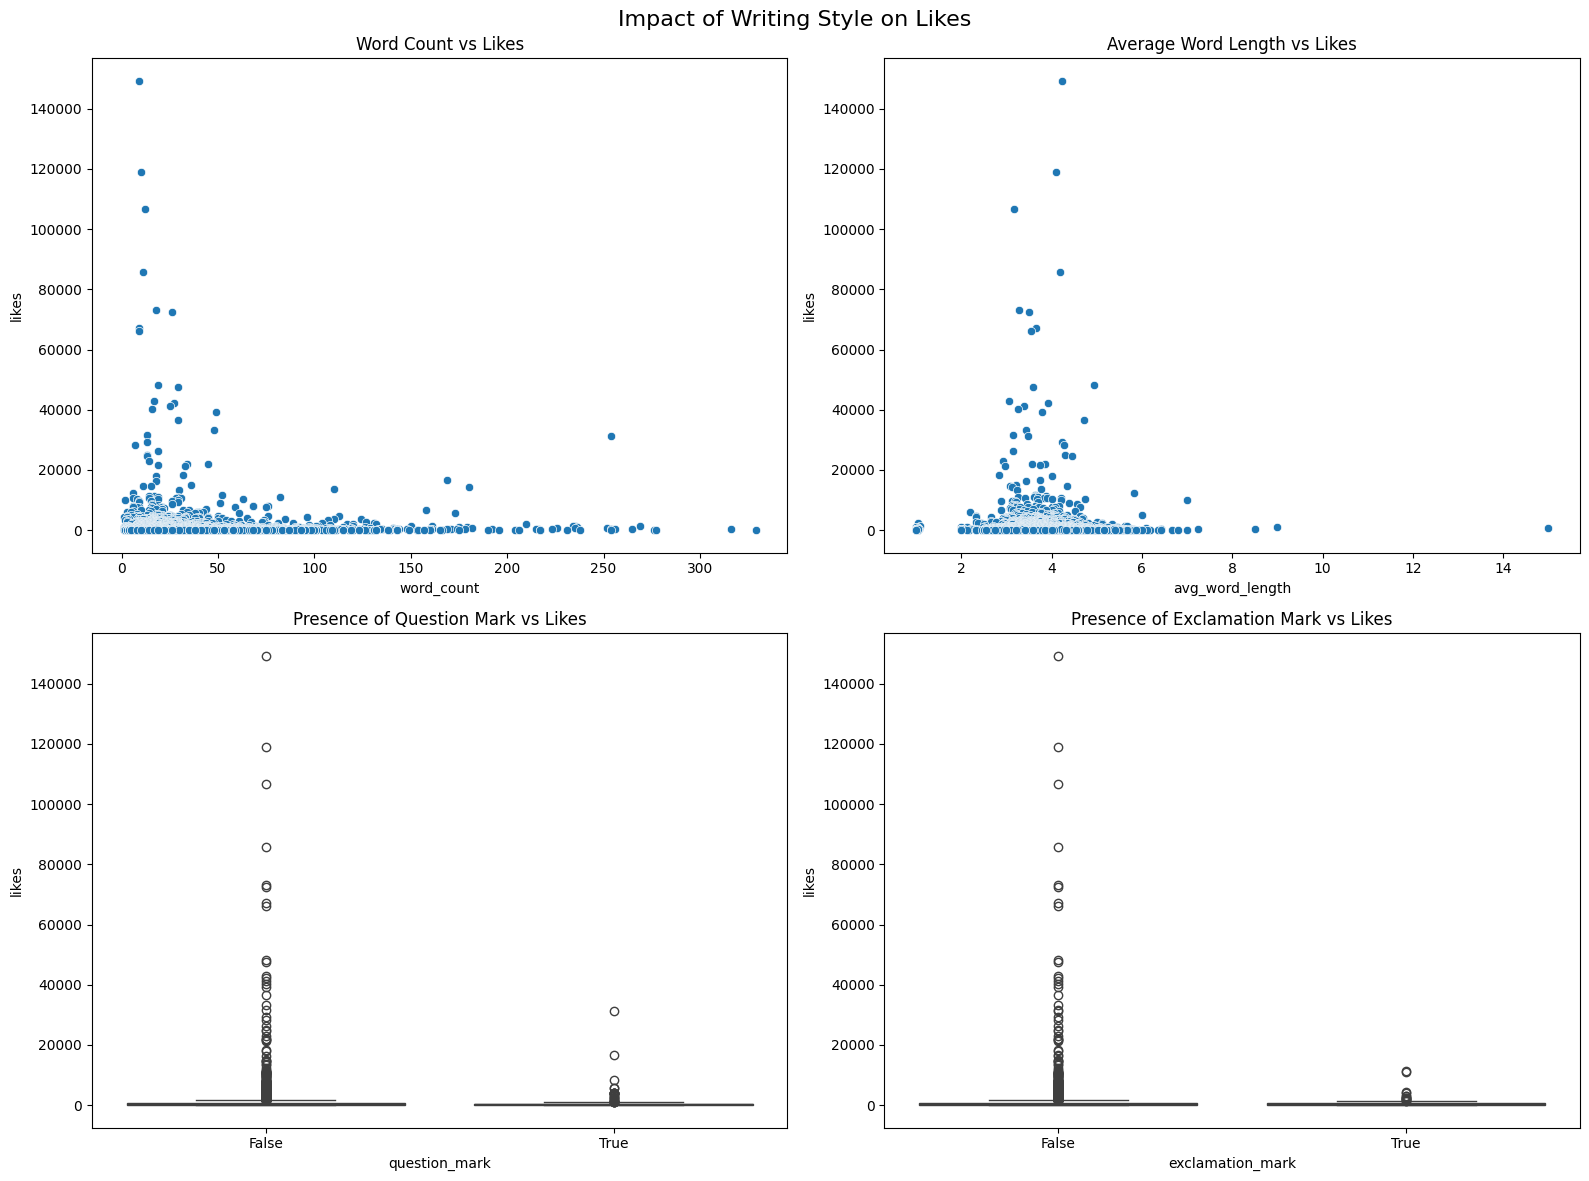

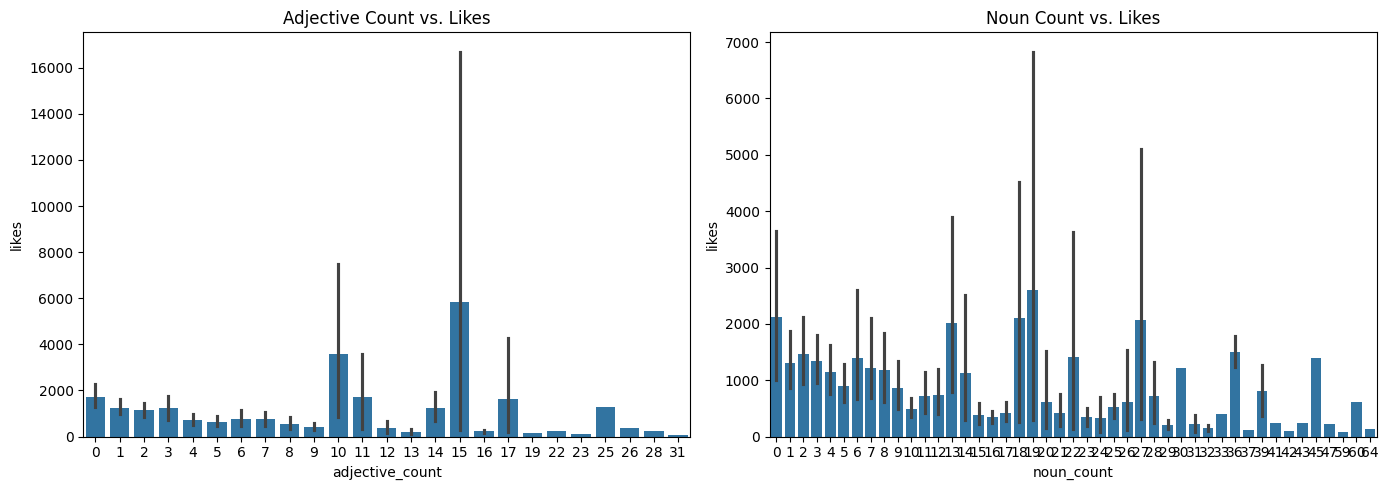

Average adjective count: 1.88
Average noun count: 4.69
Correlation between adjective count and likes: -0.03
Correlation between noun count and likes: -0.03


In [12]:
print("\nAnalyzing writing styles...")
style_correlations, _ = analyzer.analyze_writing_styles()
print("\nWriting Style Correlations with Likes:")
for style, corr in sorted(style_correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{style}: {corr:.3f}")
analyzer.visualize_writing_style_impact()
analyzer.analyze_pos_features()

The writing style analysis revealed some unexpected patterns. Both adjective and noun usage showed slight negative correlations with likes (-0.03 for both), suggesting that simpler, less descriptive quotes might perform marginally better. The average quote contains 1.88 adjectives and 4.69 nouns, indicating that successful quotes tend to be relatively concise in their composition.

This finding challenges the common assumption that more descriptive or complex writing necessarily leads to better engagement. Instead, it suggests that accessibility and clarity might be more valuable on the platform.

### Part 5: Topic and Tag Analysis

I'll be using several complementary approaches:

- `perform_topic_modeling()`: Latent Dirichlet Allocation (LDA) for unsupervised topic discovery
- `visualize_tag_cooccurrence()`: Analyzes tag relationships using network graphs
- Hierarchical clustering of related topics

For discovering underlying themes in the quotes, I implemented Latent Dirichlet Allocation (LDA). I chose this approach because quotes, like most pieces of literature, rarely stick to just one topic - usually being an amalgam of interweaving themes. LDA seeks to unravel this by treating each quote as a mixture of topics, and each topic as a mixture of words. More specifically, being an unsupervised learning algorithm, it iteratively adjusts these mixtures to find the most likely combination that could have generated the observed collection of quotes.

What makes LDA particularly suitable for this analysis is its ability to handle the ambiguous nature of literary quotes, where multiple themes often coexist. The algorithm uses Gibbs sampling, a Markov Chain Monte Carlo method, to approximate the posterior distribution of topics. This not only tells me what topics are present but also how confident we can be about these assignments. I find this particularly fascinating as it helps to understand not just what themes are present, but how strongly they come through in different quotes.

I also wanted to understand how different tags relate to each other, so I turned to network theory. By representing tags as nodes and their co-occurrences as edges, we can identify clusters of related concepts and examine how these thematic groupings influence quote popularity. The visualization uses force-directed graph layouts to naturally group related tags together, making it easier to identify thematic clusters.


Analyzing tag patterns...
Number of unique tags: 2657
Top 10 most common tags: [('inspirational', 2996), ('life', 631), ('inspirational-quotes', 309), ('inspiration', 271), ('motivational', 271), ('living', 258), ('inspiring', 244), ('life-quotes', 237), ('love', 234), ('optimism', 225)]


<ipython-input-2-76fb3649afa1>:506: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tag_co_matrix = pd.DataFrame(index=unique_tags, columns=unique_tags).fillna(0)


Co-occurrence matrix shape: (2657, 2657)
Non-zero entries in co-occurrence matrix: 77132


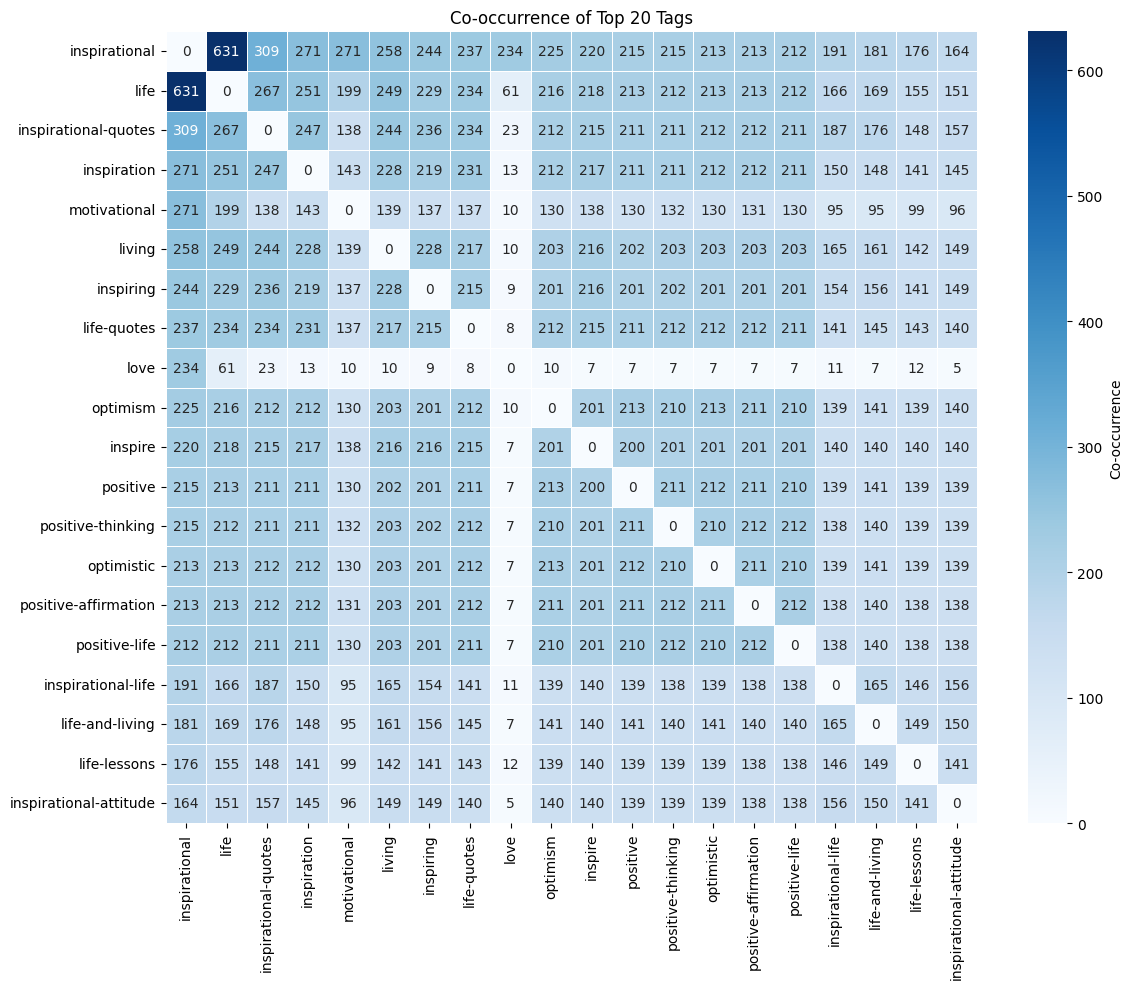


Performing topic modeling...

Top words for each topic:
Topic 0: 0.011*"love" + 0.011*"everything" + 0.008*"one" + 0.008*"something" + 0.008*"life" + 0.007*"heart" + 0.007*"world" + 0.007*"self" + 0.006*"someone" + 0.005*"good"
Topic 1: 0.018*"live" + 0.015*"life" + 0.008*"one" + 0.008*"people" + 0.008*"world" + 0.007*"every" + 0.007*"stand" + 0.006*"us" + 0.005*"dreams" + 0.005*"kind"
Topic 2: 0.018*"one" + 0.011*"love" + 0.009*"life" + 0.009*"take" + 0.009*"know" + 0.006*"man" + 0.006*"nothing" + 0.006*"come" + 0.005*"better" + 0.005*"never"
Topic 3: 0.017*"one" + 0.014*"life" + 0.012*"people" + 0.010*"time" + 0.010*"going" + 0.010*"way" + 0.009*"person" + 0.008*"always" + 0.008*"things" + 0.008*"never"
Topic 4: 0.012*"things" + 0.011*"never" + 0.010*"us" + 0.009*"one" + 0.009*"life" + 0.008*"world" + 0.007*"know" + 0.006*"feel" + 0.006*"like" + 0.006*"thing"
Topic 5: 0.034*"life" + 0.017*"people" + 0.013*"make" + 0.010*"change" + 0.010*"let" + 0.009*"love" + 0.008*"things" + 0.008*

In [13]:
print("\nAnalyzing tag patterns...")
analyzer.visualize_tag_cooccurrence()
print("\nPerforming topic modeling...")
lda_model, _ = analyzer.perform_topic_modeling()
print("\nTop words for each topic:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

The tag analysis revealed "inspirational" as the dominant tag with 2,996 occurrences, followed by "life" (631) and "inspirational-quotes" (309). This hierarchy of tags provides insight into what content resonates most with the Goodreads community.

The topic modeling revealed distinct thematic clusters:


*   Topic 0 centers around emotional themes (love, heart, world)
*   Topic 1 focuses on life philosophy and motivation (live, life, dreams)
*   Topic 2 combines love and life wisdom
*   Topic 3 deals with time and human nature
*   Topic 4 emphasizes worldly observations
*   Topic 5 appears to focus on life changes and personal growth

This distribution suggests that successful quotes often fall into clear thematic categories, with personal growth and emotional wisdom being particularly prominent.

### Part 6: Quote Similarity and Clustering

Using embedding-based analysis:

- `visualize_quote_embeddings()`: Transformer-based embeddings for semantic representation
- `visualize_quote_clusters()`: K-means clustering for quote categorization
- t-SNE dimensionality reduction for visualization

For comparing quotes, I needed something more sophisticated than simple word matching. This led me to MPNet (Multi-Pooling Network), which creates "embeddings". Unlike simpler word embedding approaches, MPNet considers the entire context of a quote when generating embeddings. This is crucial for capturing the semantic relationships between quotes that might use different words to express similar ideas.

To group similar quotes together, I implemented K-means clustering on these embeddings. K-means works by iteratively assigning quotes to clusters and updating cluster centers until convergence. The number of clusters is optimized using silhouette analysis, which measures how similar quotes are to their own cluster compared to other clusters, so as to ensure I wasn't creating arbitrary groupings.

The t-SNE (t-Distributed Stochastic Neighbor Embedding) dimensionality reduction technique is used for visualization. t-SNE is particularly well-suited for this task because it preserves local relationships between quotes while making the high-dimensional embedding space accessible in two dimensions. This allows me to visualize how quotes relate to each other while maintaining meaningful distances between similar quotes.


Visualizing quote embeddings and clusters...
Generating embeddings for 997 quotes...


  0%|          | 0/32 [00:00<?, ?it/s]

Applying t-SNE...
Plotting results...


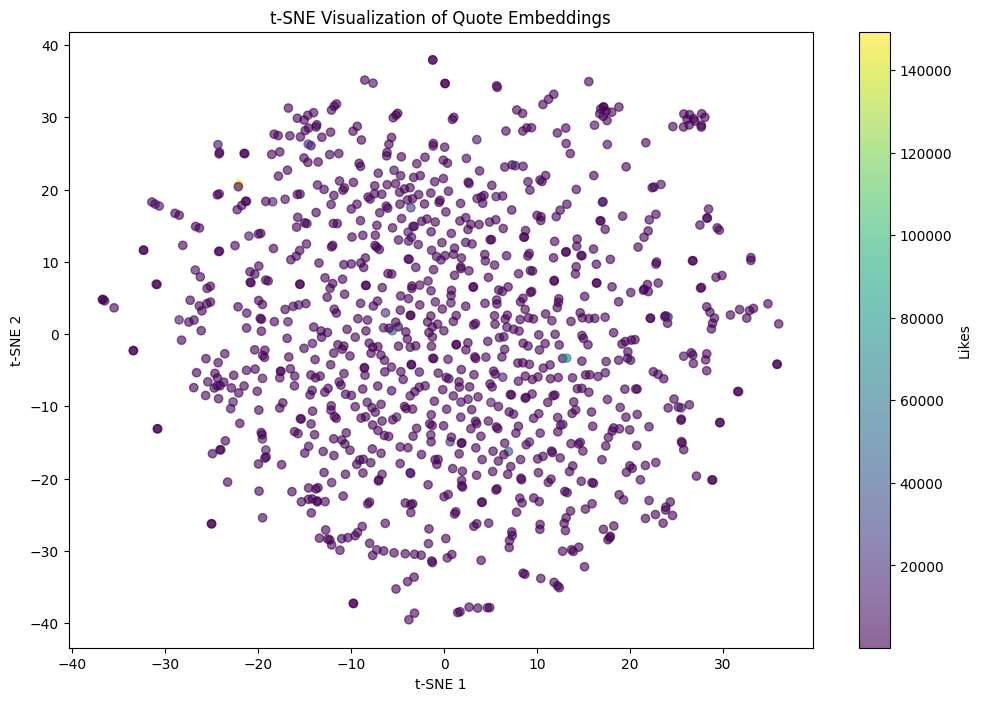

  0%|          | 0/32 [00:00<?, ?it/s]

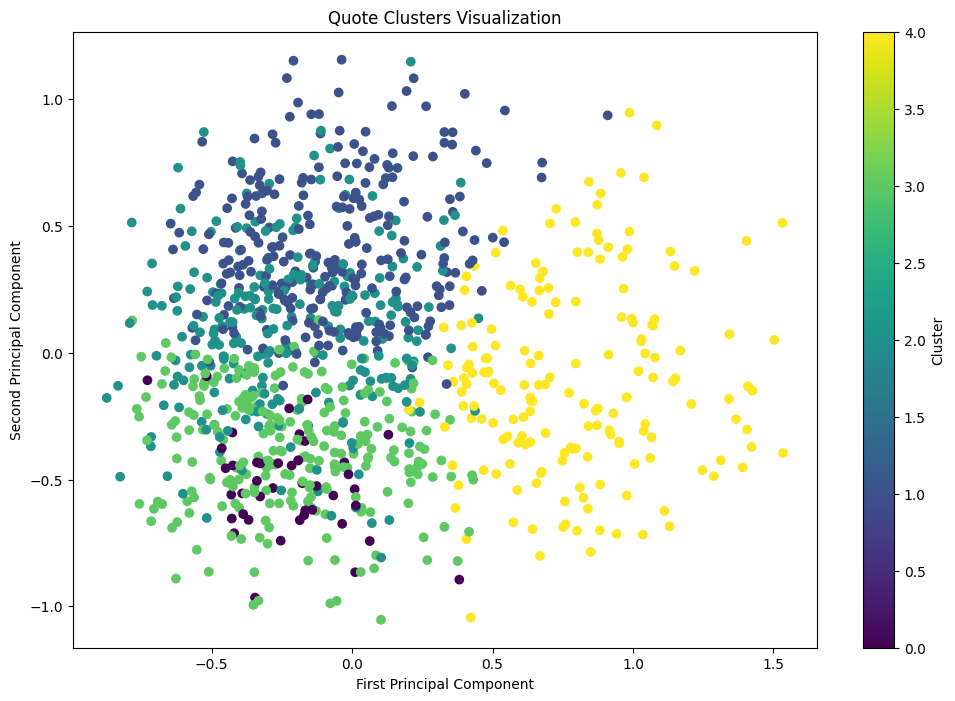

In [14]:
print("\nVisualizing quote embeddings and clusters...")
analyzer.visualize_quote_embeddings()
analyzer.visualize_quote_clusters()

The embedding visualizations reveal distinct clusters of quotes, suggesting that certain types of content tend to group together based on semantic similarity. These clusters likely represent different approaches to wisdom-sharing or different philosophical perspectives that resonate with distinct audience segments.

### Part 7: Author Relationships and Thought Lineages

In this section, I'll examine connections between authors:

- `analyze_author_network()`: Graph-based representation of author relationships
- `visualize_thought_lineages()`: Maps influence patterns
- Community detection
- Centrality analysis

One of my most exciting explorations was mapping out how different authors relate to each other based on their quotes. I created a network where authors are connected based on both how similar their quotes are and what tags they commonly share. More specifically, authors are nodes and edges represent significant similarities in their quotes or shared thematic elements. The relationships are weighted using a composite score that considers both quote similarity (based on the embeddings discussed earlier) and tag overlap. This is akin to creating a map of literary influence and shared thinking patterns.

I used the Louvain method for finding communities within this network - where one can think of it as finding "schools of thought" among authors. Idealistically, this is to reveal clusters of authors who share similar writing styles or thematic focuses, even if they're from different time periods or cultures. The community detection algorithm optimizes modularity – a measure of the density of connections within communities compared to connections between communities.

To identify the most influential authors, I used eigenvector centrality metrics. This doesn't just count how many connections an author has; it considers the importance of who they're connected to. It would be like measuring not just how many friends you have, but how well-connected those friends are themselves. This is all to provide a more nuanced view of influence within the literary network.


Analyzing author networks...
Number of authors in the network: 1060
Number of connections: 63426
Generating quote embeddings...


  0%|          | 0/32 [00:00<?, ?it/s]

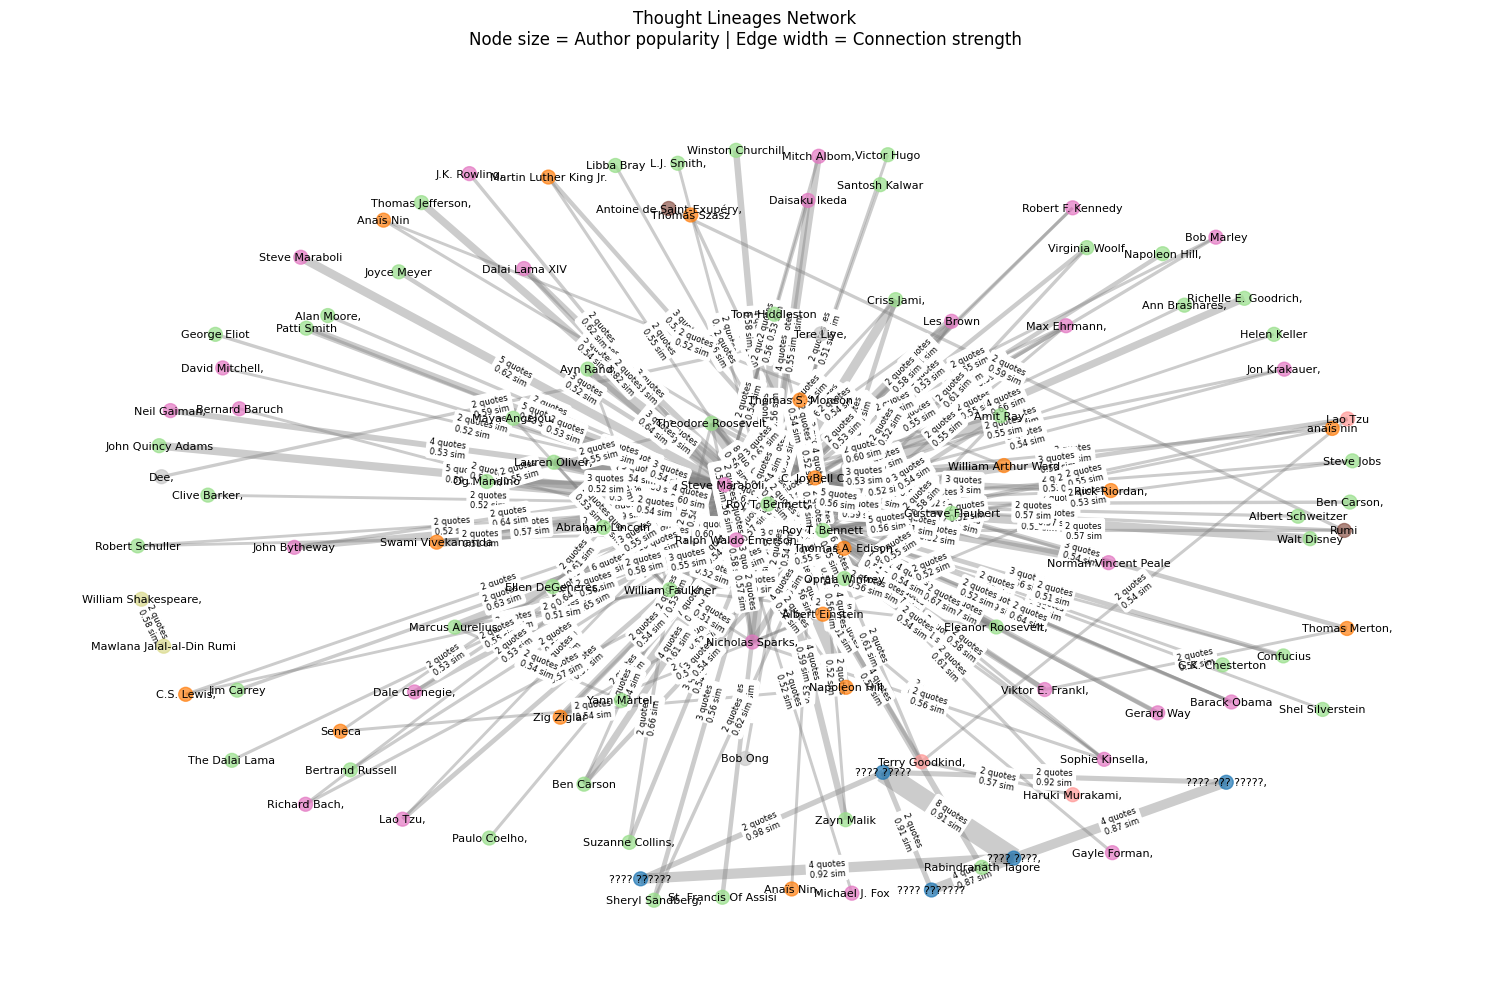


Network Statistics:
Number of authors: 112
Number of connections: 234
Number of communities: 8

Most influential authors (by eigenvector centrality):
Roy T. Bennett,: 0.636
Roy T. Bennett: 0.511
Steve Maraboli,: 0.401
William Faulkner: 0.130
Ralph Waldo Emerson: 0.124


In [15]:
print("\nAnalyzing author networks...")
author_network = analyzer.analyze_author_network()
print(f"Number of authors in the network: {len(author_network.nodes())}")
print(f"Number of connections: {len(author_network.edges())}")
analyzer.visualize_thought_lineages()

The network analysis identified 112 authors with significant connections, forming 8 distinct communities. Roy T. Bennett emerged as the most influential author based on eigenvector centrality (0.636), followed by another instance of their name (likely due to slight variations in attribution) at 0.511. This suggests that Bennett's quotes not only resonate well with readers but also share thematic connections with other influential authors.

The presence of traditional philosophers like Ralph Waldo Emerson among the most influential authors (0.124) suggests that classical wisdom continues to maintain relevance and influence in contemporary quote sharing.

### Part 8: Popularity Prediction Model

Using `predict_quote_popularity()`, the final section combines features from previous analyses into a predictive model:

- Random Forest regression for popularity prediction
- Feature importance analysis
- Cross-validated performance metrics

For the final section of this analysis, I built a Random Forest regressor to predict quote popularity. I chose this approach because it's particularly well-suited for this task as it can capture non-linear relationships and handle the diverse feature set we've generated throughout the analysis.

The model incorporates features from all previous analyses: semantic embeddings, structural characteristics, sentiment scores, and author metrics. Feature importance is calculated using permutation importance rather than built-in feature importance scores, as this provides a more reliable measure of each feature's contribution to predictive accuracy.

For robustness, I used cross-validation, with the data split into training and testing sets in a way that preserves the temporal structure of quote popularity. This approach provides a more realistic assessment of the model's ability to predict the popularity of new quotes.

In [5]:
print("\nTraining popularity prediction model...")
prediction_results = analyzer.predict_quote_popularity()
print("\nPopularity Prediction Results:")
print(f"Test R-squared score: {prediction_results['test_score']:.3f}")


Training popularity prediction model...


  0%|          | 0/32 [00:00<?, ?it/s]

Embeddings: 1000, Sample DF: 1000

Popularity Prediction Results:
Test R-squared score: -0.704


The negative R-squared score (-0.704) on the test set indicates that predicting quote popularity is extremely challenging, and our current model performs worse than a horizontal line. This suggests that quote popularity might be influenced by factors beyond the textual features we've analyzed, such as:

*   The timing of quote posting
*   Network effects
*   External events
*   The author's current cultural relevance
*   Platform-specific factors

This limitation in predictability highlights the complex nature of content popularity on social platforms and suggests that success might depend on a combination of factors that are difficult to capture in purely textual analysis.

## Conclusion

As I wrap up this deep dive into Goodreads quotes, I'm amazed at how many fascinating patterns emerged when combining natural language processing, sentiment analysis, and network analysis. This multi-faceted approach revealed insights I might have missed with simpler methods. It's quite interesting how such approaches differ from what is typical in academic econometrics and statistics.

Perhaps the most surprising discovery was about emotional content. While using BERT-based sentiment analysis, I found that while very positive quotes performed best compared to very negative quotes, the surprisingly low correlation between sentiment and likes suggests that emotional content alone doesn't determine a quote's success. The high standard deviation across all sentiment categories further reinforces that the relationship between emotional content and engagement is more complex than initially assumed.

The network analysis of authors turned out to be particularly enlightening. By looking at how authors connected and influenced each other, I uncovered entire communities of writers sharing similar philosophical or stylistic approaches, identifying 8 distinct communities among 112 significantly connected authors. It's like mapping the family tree of literary influence - showing connections that would never have spotted just reading the quotes in isolation.

When it comes to predicting quote popularity, the negative R-squared score on the test set revealed a humbling truth: the factors that make quotes resonate are more complex than our current models can capture. Surface-level characteristics like length, number of tags, and even writing complexity showed minimal impact on popularity. This suggests that quote success might depend more on external factors like timing, network effects, and cultural context than on the inherent properties of the text itself.

Looking ahead, this research opens several promising avenues for future investigation. Understanding the temporal dynamics of quote popularity, exploring the role of cultural context, and investigating the impact of network effects could provide deeper insights into content engagement. There's also potential in using more advanced language models that could better grasp metaphors and allegories - really getting at the heart of what makes quotes meaningful.

These findings have practical implications for content curation and educational material selection, but more importantly, they deepen our understanding of how written wisdom spreads and resonates across digital platforms. The results suggest that success on platforms like Goodreads isn't simply a matter of optimizing for specific metrics, but rather understanding the complex interplay between content, context, and community.